In [ ]:
import os, time, glob, socket, pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp, seaborn
import numpy as np
import numpy.linalg as LA
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns 
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
train_file = pd.read_csv("/content/gdrive/My Drive/Colab/FinTech/data/train_new.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 新的資料集：總共有1141340筆資料，22個變數，跟一個Y
train_file.shape

(1141340, 23)

In [ ]:
train_file.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056
1,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434
2,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164
3,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004
4,6411,94435,49219,1806.49,3,62,N,4,N,N,0,5,N,0,6,172624.0,339,0,N,5865,102,0,1622153


**資料說明**   
*  總比數：1141340
*  授權期間：1-120日  
*  訓練集：1-90日  
*  測試集：91-120日
---
**欄位說明(數字代表類別總數)**

*   acqic：收單行代碼  [categorical] 5524
*   bacno：歸戶帳號  [categorical] 92602
*   cano：交易卡號  [categorical] 124310
*   conam：交易金額-台幣 [numeric] 
*   contup：交易類型  [categorical] 7
*   csmcu：消費地幣別  [categorical] 66
*   ecfg：網路交易註記  [dummy] 2
*   etymd：交易型態  [categorical] 11
*   flbmk：Fallback 註記  [dummy] 2
*   flg_3dsmk：3DS 交易註記  [dummy] 2
*   hcefg：支付形態  [categorical] 9
*   insfg：分期交易註記  [dummy] 2
*   iterm：分期期數  [categorical] 9
*   locdt：授權日期  [numeric] 
*   loctm：授權時間  [numeric] 
*   mcc：MCC_CODE  [categorical] 418
*   mchno：特店代號  [categorical] 78435
*   ovrlt：超額註記碼  [dummy] 2
*   scity：消費城市  [categorical] 5026
*   stocn：消費地國別  [categorical] 98
*   stscd：狀態碼  [categorical] 5
*   txkey：交易序號  [categorical] - 從模型中移除，為是ID

*   fraud_ind：盜刷註記  [dummy] 2

In [ ]:
train_file.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'],
      dtype='object')

In [ ]:
# 其中，有遺失值的變數為flbmk與flg_3dsmk
train_file.isnull().sum()

acqic           0
bacno           0
cano            0
conam           0
contp           0
csmcu           0
ecfg            0
etymd           0
flbmk        9405
flg_3dsmk    9405
fraud_ind       0
hcefg           0
insfg           0
iterm           0
locdt           0
loctm           0
mcc             0
mchno           0
ovrlt           0
scity           0
stocn           0
stscd           0
txkey           0
dtype: int64

In [ ]:
# 1141340，代表 flbmk 發生缺漏值的觀察值與 flg_3dsmk 發生缺漏值的觀察值都一樣
sum(train_file['flbmk'].isnull() == train_file['flg_3dsmk'].isnull())

1141340

### Exploratory Data Analysis

#### For Y：fraud_ind

In [ ]:
# 總共只有 1.3%的資料為盜刷
sum(train_file['fraud_ind'])/len(train_file['fraud_ind'])

0.013390400757004924

0    1126057
1      15283
Name: fraud_ind, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


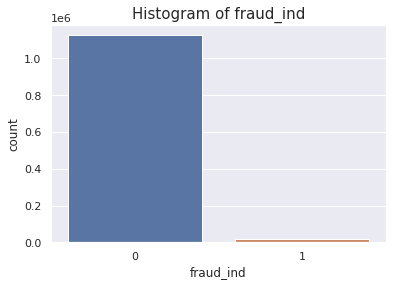

In [ ]:
print(train_file['fraud_ind'].value_counts(sort = False))
sns.set()
plt.title("Histogram of fraud_ind",fontsize=15)
sns.countplot(train_file['fraud_ind'])

#### For X：'acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'

#### 是數字但是為類別型態的資料：acqic, bacno, cano, contp, csmcu, etymd, hcefg, iterm, mcc, mchno, scity, stocn, stscd

##### acqic：收單行代碼

In [ ]:
print(len(np.unique(train_file['acqic'])))
print(np.unique(train_file['acqic']))
print(train_file['acqic'].value_counts())
# sns.set()
# sns.countplot(train_file['acqic'])

5524
[   0    1    2 ... 6882 6883 6884]
6769    188065
6716    150743
5975     93770
6881     74466
6189     68734
         ...  
493          1
5614         1
3565         1
1515         1
2536         1
Name: acqic, Length: 5524, dtype: int64


#####  bacno：歸戶帳號

In [ ]:
print(len(np.unique(train_file['bacno'])))
print(np.unique(train_file['bacno']))
print(train_file['bacno'].value_counts())
# sns.set()
# sns.countplot(train_file['bacno'])

92602
[     1      2      3 ... 163882 163883 163884]
148859    851
155157    691
103279    575
91313     492
149363    449
         ... 
36204       1
44392       1
1959        1
30633       1
145061      1
Name: bacno, Length: 92602, dtype: int64


In [ ]:
df0 = train_file[train_file['fraud_ind'] == 0]
df1 = train_file[train_file['fraud_ind'] == 1]

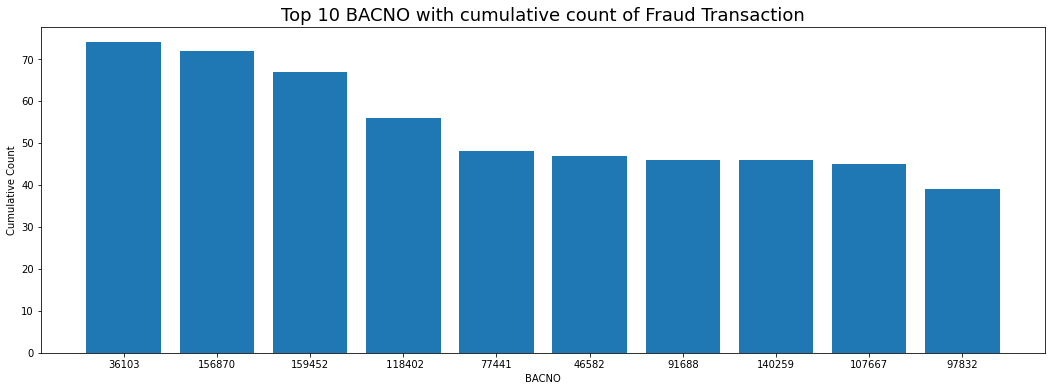

In [ ]:
df_bacno = pd.DataFrame(np.array(df1['bacno'].value_counts()), index = df1['bacno'].value_counts().index, columns=['bacno']).iloc[0:10]
plt.figure(figsize = (18,6))
x = ['36103', '156870', '159452',' 118402', '77441', '46582', '91688', '140259', '107667','97832']
y = df_bacno['bacno']

plt.bar(x,y)
plt.xlabel('BACNO')
plt.ylabel('Cumulative Count')
plt.title('Top 10 BACNO with cumulative count of Fraud Transaction', fontsize = 18)
plt.show()

##### cano：卡號

In [ ]:
print(len(np.unique(train_file['cano'])))
print(np.unique(train_file['cano']))
print(train_file['cano'].value_counts())
# sns.set()
# sns.countplot(train_file['cano'])

124310
[     0      1      2 ... 213321 213329 213334]
71502     851
174921    691
188447    575
80218     492
84432     446
         ... 
28171       1
74520       1
74903       1
89240       1
15072       1
Name: cano, Length: 124310, dtype: int64


In [ ]:
df1[df1['bacno'] == 36103]['cano']

12941      100698
18472      100698
30102      100698
31475      100698
34393      100698
            ...  
1046881    100698
1062553    100698
1091663    100698
1097409    100698
1120767    100698
Name: cano, Length: 74, dtype: int64

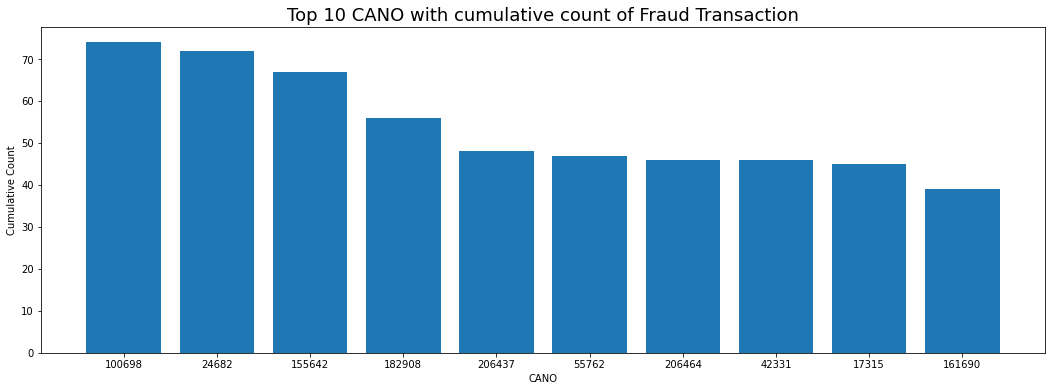

In [ ]:
df_cano = pd.DataFrame(np.array(df1['cano'].value_counts()), index = df1['cano'].value_counts().index, columns=['cano']).iloc[0:10]
plt.figure(figsize = (18,6))
x = ['100698', '24682', '155642', '182908', '206437', '55762', '206464', '42331', '17315', '161690']
y = df_cano['cano']

plt.bar(x,y)
plt.xlabel('CANO')
plt.ylabel('Cumulative Count')
plt.title('Top 10 CANO with cumulative count of Fraud Transaction', fontsize = 18)
plt.show()

##### contp：交易類別

7
[0 1 2 3 4 5 6]
0         36
1         65
2      49657
3       1625
4      52195
5    1027577
6      10185
Name: contp, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


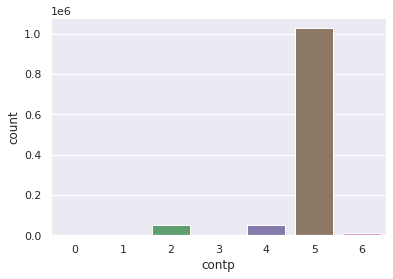

In [ ]:
print(len(np.unique(train_file['contp'])))
print(np.unique(train_file['contp']))
print(train_file['contp'].value_counts(sort = False))
sns.set()
sns.countplot(train_file['contp'])

##### csmcu：消費地幣別

66
[ 0  2  3  4  5  7 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27 28
 29 30 31 32 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 59 60 61 62 63 64 66 67 68 69 70 71 72 73 74 75]
0     132365
2          4
3         35
4       1217
5          4
       ...  
71      5510
72         1
73        85
74        89
75      9405
Name: csmcu, Length: 66, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


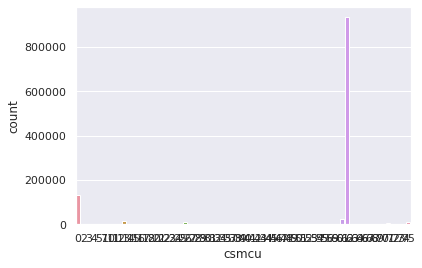

In [ ]:
print(len(np.unique(train_file['csmcu'])))
print(np.unique(train_file['csmcu']))
print(train_file['csmcu'].value_counts(sort = False))
sns.set()
sns.countplot(train_file['csmcu'])

##### etymd：交易型態

11
[ 0  1  2  3  4  5  6  7  8  9 10]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


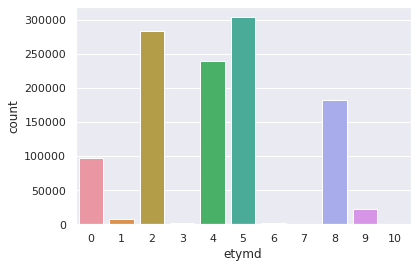

In [ ]:
print(len(np.unique(train_file['etymd'])))
print(np.unique(train_file['etymd']))
train_file['etymd'].value_counts(sort = False)
sns.set()
sns.countplot(train_file['etymd'])

##### hcefg：支付形態

9
[0 1 2 3 5 6 7 8 9]
0      40672
1      24878
2       2519
3        244
5    1058757
6       9405
7       1354
8       2863
9        648
Name: hcefg, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


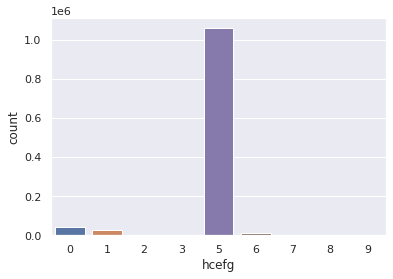

In [ ]:
print(len(np.unique(train_file['hcefg'])))
print(np.unique(train_file['hcefg']))
print(train_file['hcefg'].value_counts(sort = False))
sns.set()
sns.countplot(train_file['hcefg'])

##### iterm：分期期數

9
[0 1 2 3 4 5 6 7 8]
0    1109639
1      16945
2      11273
4       2012
7        644
3        330
8        324
6        114
5         59
Name: iterm, dtype: int64


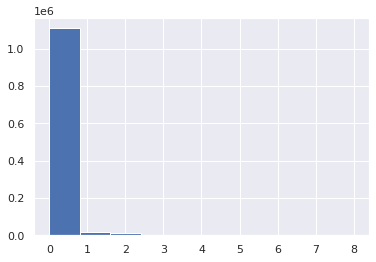

In [ ]:
print(len(np.unique(train_file['iterm'])))
print(np.unique(train_file['iterm']))
print(train_file['iterm'].value_counts())
plt.hist(train_file['iterm'])
plt.show()

##### mcc：特店類型

In [ ]:
print(len(np.unique(train_file['mcc'])))
print(np.unique(train_file['mcc']))
print(train_file['mcc'].value_counts(sort = False))
# sns.set()
# sns.countplot(train_file['mcc'])

418
[  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  29  30  31  33  34  35  36  37  39  41
  42  43  44  45  47  48  49  51  52  53  54  55  57  58  59  60  61  63
  65  66  67  68  69  70  71  72  73  74  76  77  78  79  80  81  83  84
  85  86  87  88  89  90  91  92  93  96  97  98  99 101 102 103 104 105
 106 108 109 111 112 113 114 115 116 117 118 119 120 121 122 124 125 127
 128 129 130 133 134 135 136 137 138 139 140 142 143 144 145 147 148 149
 150 151 153 155 156 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 175 176 177 178 179 180 181 183 184 186 187 188 189 190 191 192
 193 195 196 197 198 200 201 202 203 205 206 207 208 209 210 211 212 213
 214 215 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 28

##### mchno：特店名稱

In [ ]:
print(len(np.unique(train_file['mchno'])))
print(np.unique(train_file['mchno']))
print(train_file['mchno'].value_counts())
# sns.set()
# sns.countplot(train_file['mchno'])

78435
[     0      1      2 ... 103305 103306 103307]
0        37572
54828    28739
54238    27655
59333    24166
86584    15327
         ...  
56884        1
58931        1
60978        1
63025        1
509          1
Name: mchno, Length: 78435, dtype: int64


#####  scity：消費城市

In [ ]:
print(len(np.unique(train_file['scity'])))
print(np.unique(train_file['scity']))
print(train_file['scity'].value_counts())
# sns.set()
# sns.countplot(train_file['scity'])

5026
[   0    1    3 ... 6667 6669 6671]
5817    544882
0       107405
5820     64530
5800     34930
6580     30992
         ...  
2396         1
1784         1
1372         1
2808         1
2047         1
Name: scity, Length: 5026, dtype: int64


##### stocn：消費地國別

98
[  0   1   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19
  20  22  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  59  60  61  62  63  64  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97
  98 100 101 102 104 105 106 107]
102    984997
38      33338
46      31312
104     25183
75      15143
        ...  
12          1
13          1
29          1
79          1
33          1
Name: stocn, Length: 98, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


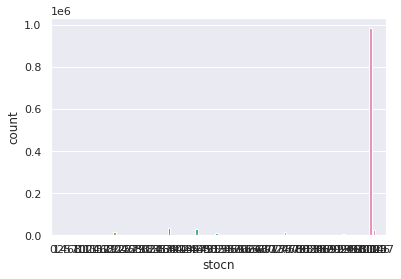

In [ ]:
print(len(np.unique(train_file['stocn'])))
print(np.unique(train_file['stocn']))
print(train_file['stocn'].value_counts())
sns.set()
sns.countplot(train_file['stocn'])

##### stscd：狀態碼

5
[0 1 2 3 4]
0    1127032
1        294
2      13913
3         88
4         13
Name: stscd, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


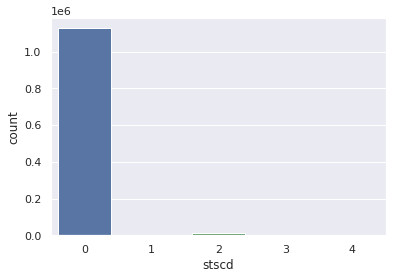

In [ ]:
print(len(np.unique(train_file['stscd'])))
print(np.unique(train_file['stscd']))
print(train_file['stscd'].value_counts(sort = False))
sns.set()
sns.countplot(train_file['stscd'])

In [ ]:
print(len(np.unique(train_file['txkey'])))

1141340


##### Y/N變數：ecfg, flbmk, flg_3dsmk, insfg, ovrlt

##### ecfg：網路交易註記

2
['N' 'Y']
Y    290139
N    851201
Name: ecfg, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


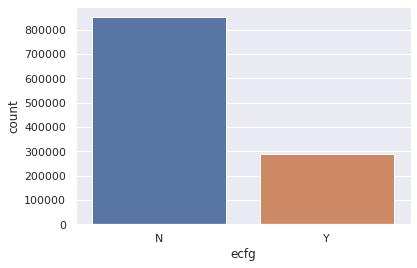

In [ ]:
print(len(np.unique(train_file['ecfg'])))
print(np.unique(train_file['ecfg']))
print(train_file['ecfg'].value_counts(sort = False))
sns.set()
sns.countplot(train_file['ecfg'])

##### flbmk：fallback註記

In [ ]:
# 因為'flbmk'有遺失值，為了看出結果先刪除再看分布(但不會刪原始資料的)
flbmk = train_file['flbmk']
flbmk = flbmk.dropna()
flbmk

0          N
1          N
2          N
3          N
4          N
          ..
1138702    N
1138703    N
1138704    N
1138705    N
1138707    N
Name: flbmk, Length: 1131935, dtype: object

2
['N' 'Y']
N    1128098
Y       3837
Name: flbmk, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


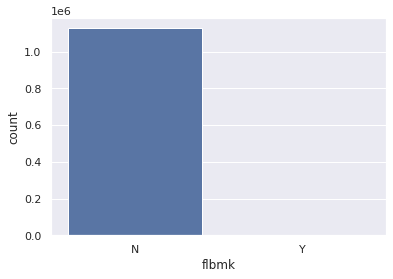

In [ ]:
print(len(np.unique(flbmk)))
print(np.unique(flbmk))
print(flbmk.value_counts())
sns.set()
sns.countplot(train_file['flbmk'])

##### flg_3dsmk：3DS交易驗證註記

2
['N' 'Y']
N    1083749
Y      48186
Name: flg_3dsmk, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


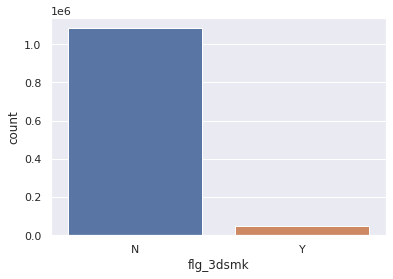

In [ ]:
# 因為'flg_3dsmk'有遺失值，為了看出結果先刪除再看分布(但不會刪原始資料的)
flg_3dsmk = train_file['flg_3dsmk']
flg_3dsmk = flg_3dsmk.dropna()
print(len(np.unique(flg_3dsmk)))
print(np.unique(flg_3dsmk))
print(flg_3dsmk.value_counts())
sns.set()
sns.countplot(train_file['flg_3dsmk'])

##### insfg：分期交易註記

2
['N' 'Y']
N    1109626
Y      31714
Name: insfg, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


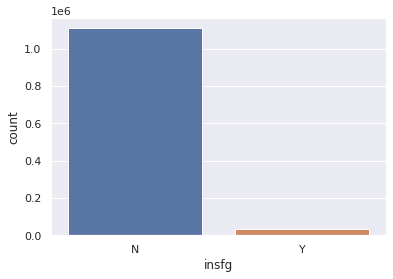

In [ ]:
print(len(np.unique(train_file['insfg'])))
print(np.unique(train_file['insfg']))
print(train_file['insfg'].value_counts())
sns.set()
sns.countplot(train_file['insfg'])

##### ovrlt：超額註記碼

2
['N' 'Y']
N    1126179
Y      15161
Name: ovrlt, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


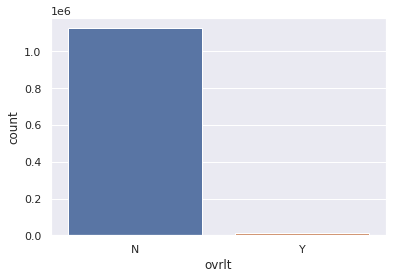

In [ ]:
print(len(np.unique(train_file['ovrlt'])))
print(np.unique(train_file['ovrlt']))
print(train_file['ovrlt'].value_counts())
sns.set()
sns.countplot(train_file['ovrlt'])

以下做的是：以各變數的值作為分母，各變數的值且是否為盜刷作為分子

In [ ]:
# Y = 0 與 Y = 1 的比例
print(round(train_file[train_file['fraud_ind'] == 0].shape[0]/train_file.shape[0], 3))
print(round(train_file[train_file['fraud_ind'] == 1].shape[0]/train_file.shape[0], 3))

0.987
0.013


In [ ]:
# ecfg = N & ecfg = Y 其中 Y = 0 與 Y = 1 的比例
print(round(train_file[(train_file['ecfg'] == 'N') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['ecfg'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['ecfg'] == 'N') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['ecfg'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['ecfg'] == 'Y') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['ecfg'] == 'Y'].shape[0], 3))
print(round(train_file[(train_file['ecfg'] == 'Y') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['ecfg'] == 'Y'].shape[0], 3))

0.997
0.003
0.955
0.045


In [ ]:
# flbmk = N & flbmk = Y 其中 Y = 0 與 Y = 1 的比例：非遺失值的(drop missing)
print(round(train_file[(train_file['flbmk'] == 'N') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['flbmk'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['flbmk'] == 'N') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['flbmk'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['flbmk'] == 'Y') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['flbmk'] == 'Y'].shape[0], 3))
print(round(train_file[(train_file['flbmk'] == 'Y') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['flbmk'] == 'Y'].shape[0], 3))

0.987
0.013
0.983
0.017


In [ ]:
# flbmk missing 中的 Y = 0 與 Y = 1 的比例
print(1-round(train_file[train_file['flbmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['flbmk'].isnull() == True].shape[0], 3))
print(round(train_file[train_file['flbmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['flbmk'].isnull() == True].shape[0], 3))

0.983
0.017


In [ ]:
# flg_3dsmk = N & flg_3dsmk = Y 其中 Y = 0 與 Y = 1 的比例：非遺失值的(drop missing)
print(round(train_file[(train_file['flg_3dsmk'] == 'N') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['flg_3dsmk'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['flg_3dsmk'] == 'N') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['flg_3dsmk'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['flg_3dsmk'] == 'Y') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['flg_3dsmk'] == 'Y'].shape[0], 3))
print(round(train_file[(train_file['flg_3dsmk'] == 'Y') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['flg_3dsmk'] == 'Y'].shape[0], 3))

0.986
0.014
0.998
0.002


In [ ]:
# flg_3dsmk missing 中的 Y = 0 與 Y = 1 的比例
print(1-round(train_file[train_file['flg_3dsmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['flg_3dsmk'].isnull() == True].shape[0], 3))
print(round(train_file[train_file['flg_3dsmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['flg_3dsmk'].isnull() == True].shape[0], 3))

0.983
0.017


In [ ]:
# insfg = N & insfg = Y 其中 Y = 0 與 Y = 1 的比例
print(round(train_file[(train_file['insfg'] == 'N') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['insfg'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['insfg'] == 'N') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['insfg'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['insfg'] == 'Y') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['insfg'] == 'Y'].shape[0], 3))
print(round(train_file[(train_file['insfg'] == 'Y') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['insfg'] == 'Y'].shape[0], 3))

0.986
0.014
0.999
0.001


In [ ]:
# ovrlt = N & ovrlt = Y 其中 Y = 0 與 Y = 1 的比例
print(round(train_file[(train_file['ovrlt'] == 'N') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['ovrlt'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['ovrlt'] == 'N') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['ovrlt'] == 'N'].shape[0], 3))
print(round(train_file[(train_file['ovrlt'] == 'Y') & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['ovrlt'] == 'Y'].shape[0], 3))
print(round(train_file[(train_file['ovrlt'] == 'Y') & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['ovrlt'] == 'Y'].shape[0], 3))

0.987
0.013
0.969
0.031


以下做的是：以 fraud_ind = 0 或 fraud_ind = 1 為分母，該變數為 N 或 Y 且 fraud_ind = 0 或 fraud_ind = 1 為分子：ecfg, flbmk, flg_3dsmk, insfg, ovrlt

In [ ]:
# 在 fraud_ind = 0 的情況下，ecfg = N & ecfg = Y 的比例
print(round(train_file[(train_file['ecfg'] == "N") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['ecfg'] == "Y") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，ecfg = N & ecfg = Y 的比例
print(round(train_file[(train_file['ecfg'] == "N") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['ecfg'] == "Y") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.754
0.246
0.14
0.86


In [ ]:
# 在 fraud_ind = 0 的情況下，flbmk = N & flbmk = Y & flbmk = nan 的比例
print(round(train_file[(train_file['flbmk'] == "N") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['flbmk'] == "Y") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[train_file['flbmk'].isnull() == False]['fraud_ind'].sum()/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，flbmk = N & flbmk = Y & flbmk = nan 的比例
print(round(train_file[(train_file['flbmk'] == "N") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['flbmk'] == "Y") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[train_file['flbmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.988
0.003
0.013
0.985
0.004
0.01


In [ ]:
# 在 fraud_ind = 0 的情況下，flg_3dsmk = N & flg_3dsmk = Y & flg_3dsmk = nan 的比例
print(round(train_file[(train_file['flg_3dsmk'] == "N") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['flg_3dsmk'] == "Y") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[train_file['flg_3dsmk'].isnull() == False]['fraud_ind'].sum()/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，flg_3dsmk = N & flg_3dsmk = Y & flg_3dsmk = nan 的比例
print(round(train_file[(train_file['flg_3dsmk'] == "N") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['flg_3dsmk'] == "Y") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[train_file['flg_3dsmk'].isnull() == True]['fraud_ind'].sum()/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.949
0.043
0.013
0.985
0.005
0.01


In [ ]:
# 在 fraud_ind = 0 的情況下，insfg = N & insfg = Y 的比例
print(round(train_file[(train_file['insfg'] == "N") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['insfg'] == "Y") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，insfg = N & insfg = Y 的比例
print(round(train_file[(train_file['insfg'] == "N") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['insfg'] == "Y") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.972
0.028
0.998
0.002


In [ ]:
# 在 fraud_ind = 0 的情況下，ovrlt = N & ovrlt = Y 的比例
print(round(train_file[(train_file['ovrlt'] == "N") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['ovrlt'] == "Y") & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，ovrlt = N & ovrlt = Y 的比例
print(round(train_file[(train_file['ovrlt'] == "N") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['ovrlt'] == "Y") & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.987
0.013
0.97
0.03


In [ ]:
# 將 Y,N 轉換為 1,0
train_file['ecfg'] = (train_file['ecfg']=='Y').astype(int)
train_file['flbmk'] = (train_file['flbmk']=='Y').astype(int)
train_file['flg_3dsmk'] = (train_file['flg_3dsmk']=='Y').astype(int)
train_file['insfg'] = (train_file['insfg']=='Y').astype(int)
train_file['ovrlt'] = (train_file['ovrlt']=='Y').astype(int)

In [ ]:
train_file.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,0,0,0,0,0,5,0,0,33,172652.0,457,59333,0,0,102,0,516056
1,6881,15408,188328,513.80,5,0,0,0,0,0,0,5,0,0,6,152458.0,457,59333,0,0,102,0,483434
2,6716,157159,29967,1016.11,5,62,0,5,0,0,0,5,0,0,5,172946.0,247,50436,0,3281,102,0,1407164
3,5975,105985,81305,713.66,5,62,0,4,0,0,0,5,0,0,6,182129.0,263,93775,0,5817,102,0,1051004
4,6411,94435,49219,1806.49,3,62,0,4,0,0,0,5,0,0,6,172624.0,339,0,0,5865,102,0,1622153


#### 數值型 numeric variables：conam, locdt, loctm (後兩者需要轉換)

##### conam：交易金額-台幣 (經過轉換)

61098
[0.00000e+00 1.00000e-02 2.00000e-02 ... 6.74272e+03 6.93647e+03
 7.20877e+03]
513.80     98143
465.62     35956
0.00       35025
683.25     15117
407.87      8296
           ...  
416.23         1
431.77         1
2037.13        1
536.89         1
630.12         1
Name: conam, Length: 61098, dtype: int64


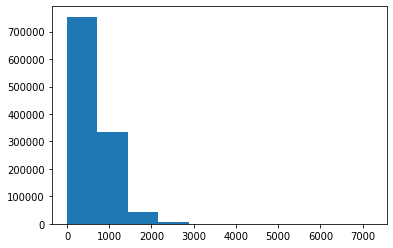

In [ ]:
print(len(np.unique(train_file['conam'])))
print(np.unique(train_file['conam']))
print(train_file['conam'].value_counts())
plt.hist(train_file['conam'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


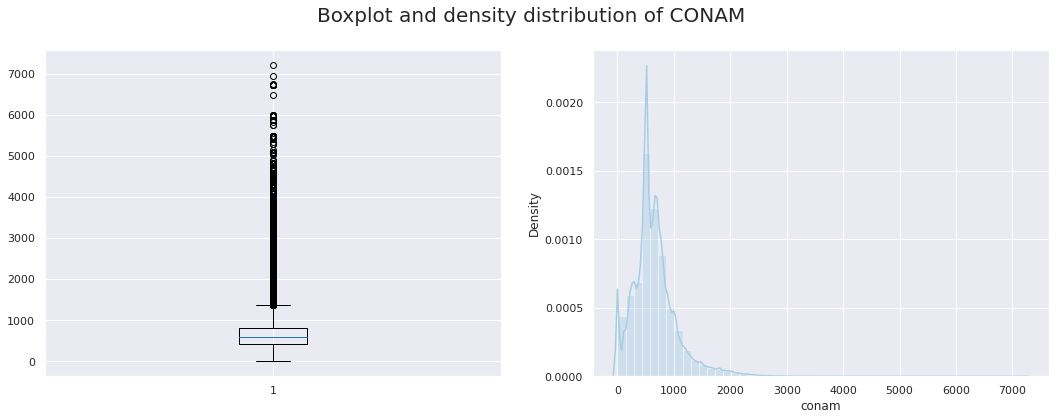

In [ ]:
# 交易金額分配
plt.figure(figsize = (18,6))
sns.set_palette('Paired')
plt.suptitle("Boxplot and density distribution of CONAM", fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(1,2,1)
plt.boxplot(train_file['conam'])
plt.subplot(1,2,2)
sns.distplot(train_file['conam']) # 繪製直方密度圖
plt.show() # 顯現圖形 

In [ ]:
sum(train_file['conam'] == 0)

35025

In [ ]:
# 有某種程度的相關性
train_file[(train_file['conam'] == 0) & (train_file['fraud_ind'] == 1)].iloc[:,0:11]

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind
1873,6215,60064,101026,0.0,5,62,0,2,0,0,1
2583,6173,7281,38647,0.0,5,61,0,2,0,0,1
5721,3581,134542,103268,0.0,5,28,1,8,0,0,1
5825,6215,26537,124647,0.0,5,62,0,2,0,0,1
6054,5720,76893,201141,0.0,5,62,1,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1130596,3288,120194,84722,0.0,5,62,1,8,0,0,1
1130726,6213,159935,99494,0.0,5,62,0,2,0,0,1
1136609,6540,91084,149814,0.0,5,61,0,2,0,0,1
1138165,3221,8288,58761,0.0,5,61,1,8,0,0,1


In [ ]:
# conam = 0 & conam != 0 其中 Y = 0 與 Y = 1 的比例
print(round(train_file[(train_file['conam'] == 0) & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['conam'] == 0].shape[0], 3))
print(round(train_file[(train_file['conam'] == 0) & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['conam'] == 0].shape[0], 3))
print(round(train_file[(train_file['conam'] != 0) & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['conam'] != 0].shape[0], 3))
print(round(train_file[(train_file['conam'] != 0) & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['conam'] != 0].shape[0], 3))

0.945
0.055
0.988
0.012


In [ ]:
# 在 fraud_ind = 0 的情況下，conam = 0 & conam != 0 的比例
print(round(train_file[(train_file['conam'] == 0) & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
print(round(train_file[(train_file['conam'] != 0) & (train_file['fraud_ind'] == 0)].shape[0]/train_file[train_file['fraud_ind'] == 0].shape[0], 3))
# 在 fraud_ind = 1 的情況下，conam = 0 & conam != 0 的比例
print(round(train_file[(train_file['conam'] == 0) & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))
print(round(train_file[(train_file['conam'] != 0) & (train_file['fraud_ind'] == 1)].shape[0]/train_file[train_file['fraud_ind'] == 1].shape[0], 3))

0.029
0.971
0.126
0.874


In [ ]:
# 將金額做 log transformation
train_file['conam_log'] = train_file['conam'].apply(lambda x: math.log(x+1))

61098
[0.         0.00995033 0.01980263 ... 8.81636698 8.84469243 8.88319233]
6.243778    98143
6.145515    35956
0.000000    35025
6.528323    15117
6.013397     8296
            ...  
7.461658        1
7.482479        1
5.580107        1
6.329543        1
7.097516        1
Name: conam_log, Length: 61098, dtype: int64


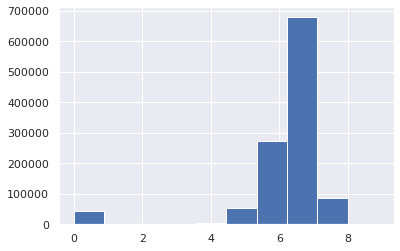

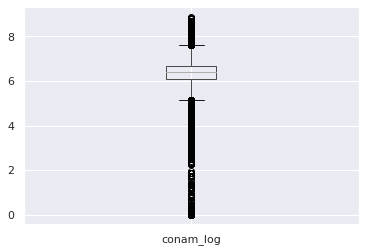

In [ ]:
print(len(np.unique(train_file['conam_log'])))
print(np.unique(train_file['conam_log']))
print(train_file['conam_log'].value_counts())
plt.hist(train_file['conam_log'])
plt.show()
train_file.boxplot(column='conam_log')
plt.show()

In [ ]:
# 將金額做 standardized
mean_c = np.mean(train_file['conam'])
std_c = np.std(train_file['conam'])
train_file['conam_z'] = train_file['conam'].apply(lambda x: (x-mean_c)/std_c)

61098
[-1.62446257 -1.62443776 -1.62441295 ... 15.10630903 15.58706264
 16.26272307]
-0.349566    98143
-0.469115    35956
-1.624463    35025
 0.070892    15117
-0.612411     8296
             ...  
 1.280356        1
 2.314392        1
 0.600403        1
 3.722758        1
 0.266295        1
Name: conam_z, Length: 61098, dtype: int64


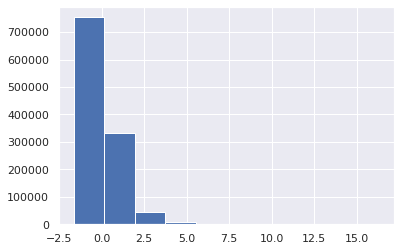

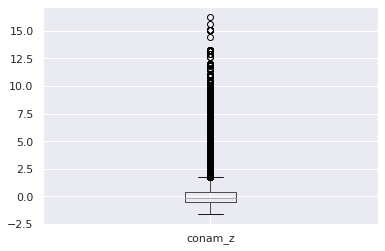

In [ ]:
print(len(np.unique(train_file['conam_z'])))
print(np.unique(train_file['conam_z']))
print(train_file['conam_z'].value_counts())
plt.hist(train_file['conam_z'])
plt.show()
train_file.boxplot(column='conam_z')
plt.show()

##### locdt：授權日期

90
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
76    16171
44    15600
83    15043
75    14448
33    14352
      ...  
84    10705
40    10676
77    10549
35    10408
79    10404
Name: locdt, Length: 90, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


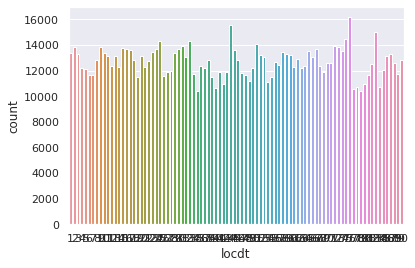

In [ ]:
print(len(np.unique(train_file['locdt'])))
print(np.unique(train_file['locdt']))
print(train_file['locdt'].value_counts())
sns.set()
sns.countplot(train_file['locdt'])
# plt.hist(train_file['locdt'])
# plt.show()

##### loctm：授權時間

83473
[0.00000e+00 1.00000e+00 2.00000e+00 ... 2.35957e+05 2.35958e+05
 2.35959e+05]
104829.0    60
104833.0    56
104636.0    56
104940.0    55
104722.0    55
            ..
33637.0      1
33643.0      1
61814.0      1
40928.0      1
54214.0      1
Name: loctm, Length: 83473, dtype: int64


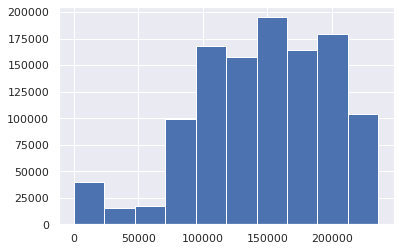

In [ ]:
print(len(np.unique(train_file['loctm'])))
print(np.unique(train_file['loctm']))
print(train_file['loctm'].value_counts())
plt.hist(train_file['loctm'])
plt.show()

##### 將 locdt (授權日期) 轉換為星期; loctm(授權時間) 轉換為小時與早中晚

In [ ]:
# locdt：不需要提
train_file['weekday'] = train_file['locdt'] % 7

7
[0 1 2 3 4 5 6]
2    174817
3    172175
4    167573
6    165348
1    162849
5    158982
0    139596
Name: weekday, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


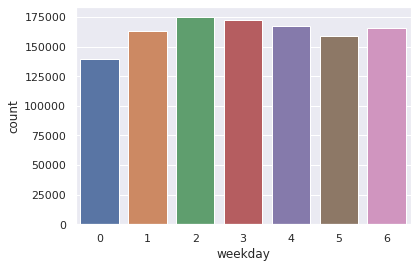

In [ ]:
print(len(np.unique(train_file['weekday'])))
print(np.unique(train_file['weekday']))
print(train_file['weekday'].value_counts())
sns.set()
sns.countplot(train_file['weekday'])

In [ ]:
# loctm
train_file['loctm_hh'] = train_file['loctm'].apply(lambda x: math.floor(x/10000))
train_file['loctm_mm'] = train_file['loctm'].apply(lambda x: math.floor(x/100)-math.floor(x/10000)*100)
train_file['loctm_ss'] = train_file['loctm'].apply(lambda x: math.floor(x)-math.floor(x/100)*100)

24
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
10    89647
17    78719
16    76474
20    75838
18    75614
19    75414
15    75212
14    73101
13    70978
12    67779
11    65007
21    62359
9     56629
22    40152
8     36795
23    29600
7     21136
0     20131
1     12123
2     10955
6      9322
3      7049
5      5723
4      5583
Name: loctm_hh, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


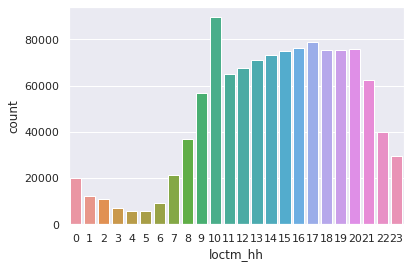

In [ ]:
print(len(np.unique(train_file['loctm_hh'])))
print(np.unique(train_file['loctm_hh']))
print(train_file['loctm_hh'].value_counts())
sns.set()
sns.countplot(train_file['loctm_hh'])

In [ ]:
# loctm_hh - 切割成早中晚
train_file['loctm_0_7'] = train_file['loctm_hh'].apply(lambda x: 1 if ((x >= 0) & (x < 8)) else 0)
train_file['loctm_8_15'] = train_file['loctm_hh'].apply(lambda x: 1 if ((x >= 8) & (x < 16)) else 0)
train_file['loctm_16_23'] = train_file['loctm_hh'].apply(lambda x: 1 if ((x >= 16) & (x <= 23)) else 0)

In [ ]:
train_file.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,conam_log,conam_z,weekday,loctm_hh,loctm_mm,loctm_ss,loctm_0_7,loctm_8_15,loctm_16_23
0,6881,113261,38038,513.80,5,0,0,0,0,0,0,5,0,0,33,172652.0,457,59333,0,0,102,0,516056,6.243778,-0.349566,5,17,26,52,0,0,1
1,6881,15408,188328,513.80,5,0,0,0,0,0,0,5,0,0,6,152458.0,457,59333,0,0,102,0,483434,6.243778,-0.349566,6,15,24,58,0,1,0
2,6716,157159,29967,1016.11,5,62,0,5,0,0,0,5,0,0,5,172946.0,247,50436,0,3281,102,0,1407164,6.924721,0.896820,5,17,29,46,0,0,1
3,5975,105985,81305,713.66,5,62,0,4,0,0,0,5,0,0,6,182129.0,263,93775,0,5817,102,0,1051004,6.571807,0.146348,6,18,21,29,0,0,1
4,6411,94435,49219,1806.49,3,62,0,4,0,0,0,5,0,0,6,172624.0,339,0,0,5865,102,0,1622153,7.499694,2.857997,6,17,26,24,0,0,1


###### 嘗試將是否盜刷的紀錄放在同一張表中

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


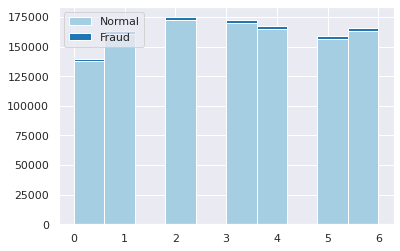

In [ ]:
df0 = train_file[train_file['fraud_ind'] == 0]
df1 = train_file[train_file['fraud_ind'] == 1]

plt.hist([df0.weekday, df1.weekday], label = ['Normal', 'Fraud'], stacked = True)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


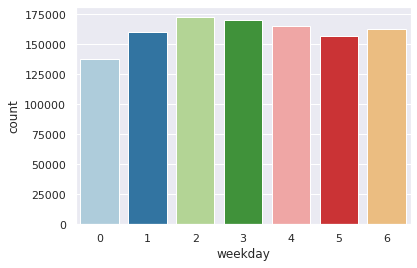

In [ ]:
# 正常交易中的星期分布
sns.set()
sns.set_palette('Paired')
sns.countplot(df0.weekday)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


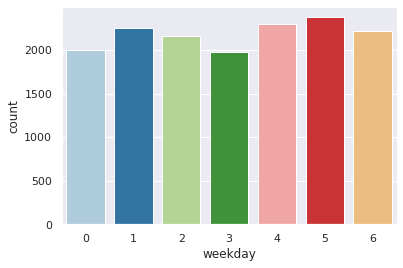

In [ ]:
# 盜刷交易中的星期分布
sns.set()
sns.set_palette('Paired')
sns.countplot(df1.weekday)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


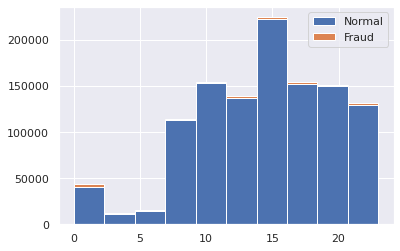

In [ ]:
plt.hist([df0.loctm_hh, df1.loctm_hh], label = ['Normal', 'Fraud'], stacked = True)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


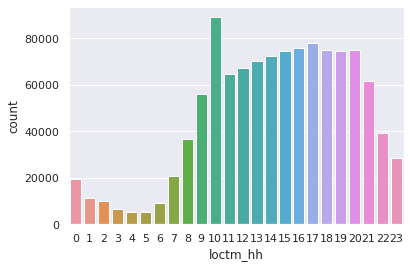

In [ ]:
# 正常交易中的時間(小時)分布
sns.set()
sns.set_palette('Paired')
sns.countplot(df0.loctm_hh)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


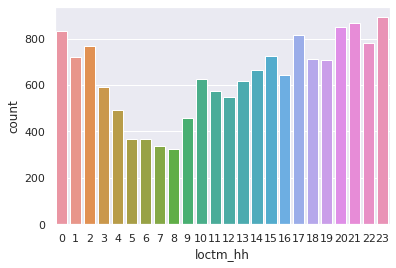

In [ ]:
sns.set()
sns.set_palette('Paired')
sns.countplot(df1.loctm_hh)

In [ ]:
train_file_sp = train_file.iloc[:,[0,1,2,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21]]
import scipy.stats
spearman_corr = scipy.stats.spearmanr(train_file_sp)

In [ ]:
print(train_file_sp.columns)
print(train_file_sp.shape)
train_file_sp.head()

Index(['acqic', 'bacno', 'cano', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk',
       'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'mcc', 'mchno',
       'ovrlt', 'scity', 'stocn', 'stscd'],
      dtype='object')
(1141340, 19)


['acqic',
 'bacno',
 'cano',
 'contp',
 'csmcu',
 'ecfg',
 'etymd',
 'flbmk',
 'flg_3dsmk',
 'fraud_ind',
 'hcefg',
 'insfg',
 'iterm',
 'mcc',
 'mchno',
 'ovrlt',
 'scity',
 'stocn',
 'stscd']

In [ ]:
spearman_corr1 = pd.DataFrame(np.array(spearman_corr)[1],index= ['acqic', 'bacno', 'cano', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk','flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'mcc', 'mchno','ovrlt', 'scity', 'stocn', 'stscd'], columns = ['acqic', 'bacno', 'cano', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk','flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'mcc', 'mchno','ovrlt', 'scity', 'stocn', 'stscd'])
for i in range(0,19):
    spearman_corr1.iloc[:,i] = spearman_corr1.iloc[:,i].apply(lambda x: round(x,3))
spearman_corr1

,acqic,bacno,cano,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,mcc,mchno,ovrlt,scity,stocn,stscd
acqic,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
bacno,0.0,0.000,0.398,0.0,0.000,0.0,0.0,0.265,0.001,0.581,0.000,0.652,0.627,0.00,0.000,0.001,0.013,0.029,0.000
cano,0.0,0.398,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.043,0.000,0.000,0.000,0.000
contp,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
csmcu,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.007,0.000,0.000,0.000
ecfg,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
etymd,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
flbmk,0.0,0.265,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.028,0.000,0.001,0.001,0.00,0.000,0.321,0.000,0.000,0.251
flg_3dsmk,0.0,0.001,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.694,0.000,0.000,0.00,0.000,0.062,0.000,0.000,0.000
fraud_ind,0.0,0.581,0.000,0.0,0.000,0.0,0.0,0.028,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000


## 卡號跟凌晨刷卡(看特性)

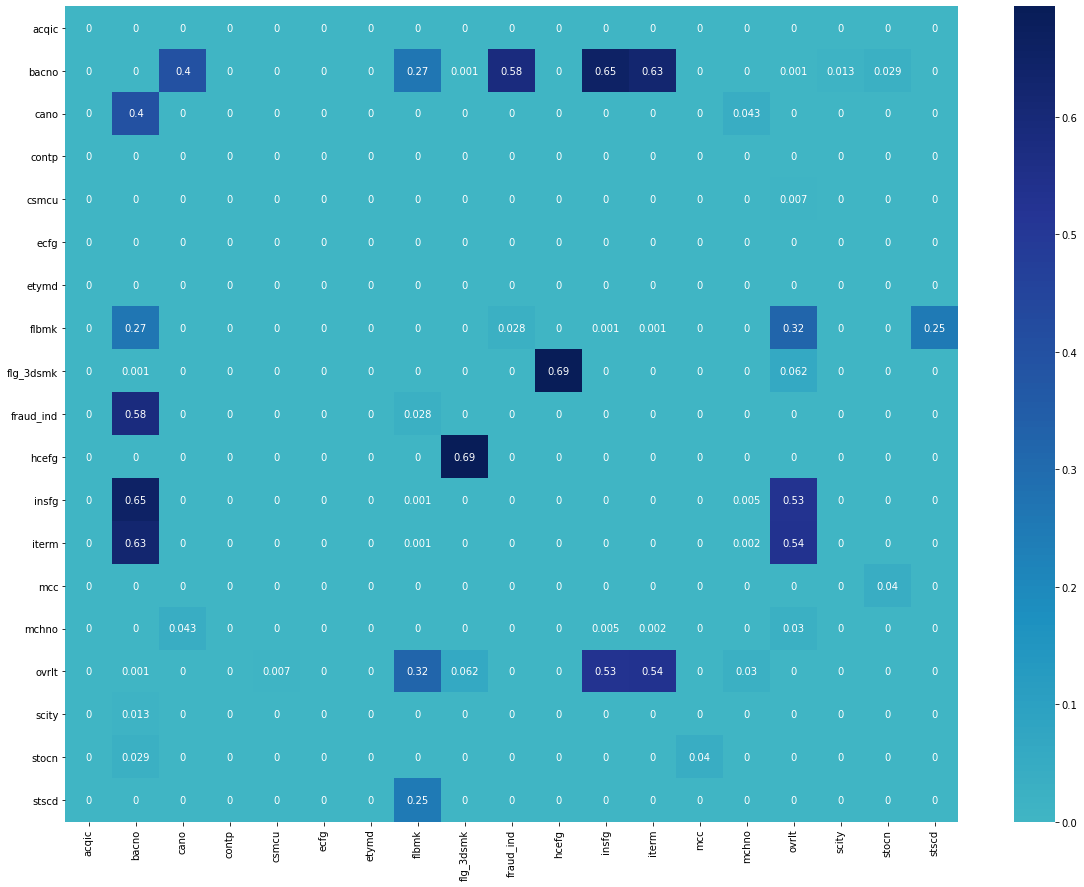

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
seaborn.heatmap(spearman_corr1, center = 0, annot = True, cmap="YlGnBu", )
mp.show()

##### 將類別變數改成dummy：acqic, bacno, cano, contp, csmcu, etymd, hcefg, mcc, mchno, scity, stocn, stscd

In [ ]:
train_file.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,conam_log,conam_z,weekday,loctm_hh,loctm_mm,loctm_ss,loctm_0_7,loctm_8_15,loctm_16_23
0,6881,113261,38038,513.80,5,0,0,0,0,0,0,5,0,0,33,172652.0,457,59333,0,0,102,0,516056,6.243778,-0.349566,5,17,26,52,0,0,1
1,6881,15408,188328,513.80,5,0,0,0,0,0,0,5,0,0,6,152458.0,457,59333,0,0,102,0,483434,6.243778,-0.349566,6,15,24,58,0,1,0
2,6716,157159,29967,1016.11,5,62,0,5,0,0,0,5,0,0,5,172946.0,247,50436,0,3281,102,0,1407164,6.924721,0.896820,5,17,29,46,0,0,1
3,5975,105985,81305,713.66,5,62,0,4,0,0,0,5,0,0,6,182129.0,263,93775,0,5817,102,0,1051004,6.571807,0.146348,6,18,21,29,0,0,1
4,6411,94435,49219,1806.49,3,62,0,4,0,0,0,5,0,0,6,172624.0,339,0,0,5865,102,0,1622153,7.499694,2.857997,6,17,26,24,0,0,1


In [ ]:
# 其他被註解掉的則是因為類別數太多，等等直接pd.get_dunnies會跑不動(RAM不夠)
#train_file['acqic'] = train_file['acqic'].astype(str)
#train_file['bacno'] = train_file['bacno'].astype(str)
#train_file['cano'] = train_file['cano'].astype(str)
train_file['contp'] = train_file['contp'].astype(str)
train_file['csmcu'] = train_file['csmcu'].astype(str)
train_file['ecfg'] = train_file['ecfg'].astype(str)
train_file['etymd'] = train_file['etymd'].astype(str)
train_file['flbmk'] = train_file['flbmk'].astype(str)
train_file['flg_3dsmk'] = train_file['flg_3dsmk'].astype(str)
train_file['hcefg'] = train_file['hcefg'].astype(str)
train_file['insfg'] = train_file['insfg'].astype(str)
train_file['iterm'] = train_file['iterm'].astype(str)
#train_file['mcc'] = train_file['mcc'].astype(str)
#train_file['mchno'] = train_file['mchno'].astype(str)
train_file['ovrlt'] = train_file['ovrlt'].astype(str)
#train_file['scity'] = train_file['scity'].astype(str)
train_file['stocn'] = train_file['stocn'].astype(str)
train_file['stscd'] = train_file['stscd'].astype(str)

In [ ]:
train_file.dtypes

acqic            int64
bacno            int64
cano             int64
conam          float64
contp           object
csmcu           object
ecfg            object
etymd           object
flbmk           object
flg_3dsmk       object
fraud_ind        int64
hcefg           object
insfg           object
iterm           object
locdt            int64
loctm          float64
mcc              int64
mchno            int64
ovrlt           object
scity            int64
stocn           object
stscd           object
txkey            int64
conam_log      float64
conam_z        float64
weekday          int64
loctm_hh         int64
loctm_mm         int64
loctm_ss         int64
loctm_0_7        int64
loctm_8_15       int64
loctm_16_23      int64
dtype: object

In [ ]:
train_file_dummies = pd.get_dummies(train_file)
pd.DataFrame(train_file_dummies)

,acqic,bacno,cano,conam,fraud_ind,locdt,loctm,mcc,mchno,scity,txkey,conam_log,conam_z,weekday,loctm_hh,loctm_mm,loctm_ss,loctm_0_7,loctm_8_15,loctm_16_23,contp_0,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,csmcu_0,csmcu_10,csmcu_11,csmcu_12,csmcu_13,csmcu_14,csmcu_15,csmcu_16,csmcu_17,csmcu_18,csmcu_2,csmcu_20,csmcu_21,...,stocn_63,stocn_64,stocn_67,stocn_68,stocn_69,stocn_7,stocn_70,stocn_71,stocn_72,stocn_73,stocn_74,stocn_75,stocn_76,stocn_77,stocn_78,stocn_79,stocn_8,stocn_80,stocn_81,stocn_82,stocn_83,stocn_84,stocn_85,stocn_86,stocn_87,stocn_89,stocn_90,stocn_91,stocn_92,stocn_93,stocn_94,stocn_95,stocn_96,stocn_97,stocn_98,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4
0,6881,113261,38038,513.80,0,33,172652.0,457,59333,0,516056,6.243778,-0.349566,5,17,26,52,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6881,15408,188328,513.80,0,6,152458.0,457,59333,0,483434,6.243778,-0.349566,6,15,24,58,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6716,157159,29967,1016.11,0,5,172946.0,247,50436,3281,1407164,6.924721,0.896820,5,17,29,46,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,5975,105985,81305,713.66,0,6,182129.0,263,93775,5817,1051004,6.571807,0.146348,6,18,21,29,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,6411,94435,49219,1806.49,0,6,172624.0,339,0,5865,1622153,7.499694,2.857997,6,17,26,24,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141335,6032,2510,54094,1.38,0,30,231435.0,248,78297,5817,196080,0.867100,-1.621038,2,23,14,35,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1141336,1801,12832,137381,1138.04,0,1,100009.0,201,198,1852,642025,7.037941,1.199366,1,10,0,9,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1141337,6322,91008,15189,578.38,0,4,191642.0,209,38222,5817,1478280,6.361959,-0.189323,4,19,16,42,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1141338,3226,145107,116252,435.32,0,13,102338.0,192,90135,1458,661087,6.078376,-0.544299,6,10,23,38,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Colab/FinTech/data/train_freq.csv')

In [ ]:
# 為了畫圖方便用
train['Period'] = train['loctm_hour'].apply(lambda x: 'Early Morning(0-7)' if ((x >= 0) & (x < 8)) else ('Daytime(8-15)' if ((x >= 8) & (x < 16)) else 'Night(16-23)'))

In [ ]:
print(len(np.unique(train['freq_bacno'])))
print(np.unique(train['freq_bacno']))
print(train['freq_bacno'].value_counts())
# sns.set()
# sns.countplot(train['freq_bacno'])

24
[ 0  1  2  3  4  7  8  9 11 15 16 17 18 20 21 24 28 29 30 33 47 48 56 67]
0     975253
1      87705
2      38258
3      16114
4       8452
7       2203
8       1263
9        565
16       367
11       293
18       207
20       189
15       173
17       157
21        98
33        93
24        91
47        89
28        73
56        70
67        67
30        64
48        48
29        43
Name: freq_bacno, dtype: int64


In [ ]:
print(len(np.unique(train['freq_cano'])))
print(np.unique(train['freq_cano']))
print(train['freq_cano'].value_counts())
# sns.set()
# sns.countplot(train['freq_cano'])

26
[ 0  1  2  3  5  7  8  9 10 11 14 17 19 20 21 24 27 28 29 30 32 38 39 47
 72 74]
0     1053483
1       44589
2       19193
3        8416
5        2107
7        1145
8         679
9         402
10        374
11        262
14        155
19        124
20        121
27        120
17        110
47         89
74         86
21         77
72         72
24         72
28         61
38         45
39         44
32         40
29         39
30         30
Name: freq_cano, dtype: int64


In [ ]:
df0 = train[train['fraud_ind'] == 0]
df1 = train[train['fraud_ind'] == 1]

In [ ]:
print(round(df0['Period'].value_counts()/df0.shape[0], 3))
print(round(df1['Period'].value_counts()/df1.shape[0], 3))

Daytime(8-15)         0.472
Night(16-23)          0.451
Early Morning(0-7)    0.077
Name: Period, dtype: float64
Night(16-23)          0.410
Daytime(8-15)         0.296
Early Morning(0-7)    0.294
Name: Period, dtype: float64


Daytime(8-15)         526940
Night(16-23)          503524
Early Morning(0-7)     86344
Name: Period, dtype: int64
Night(16-23)          6201
Daytime(8-15)         4475
Early Morning(0-7)    4451
Name: Period, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


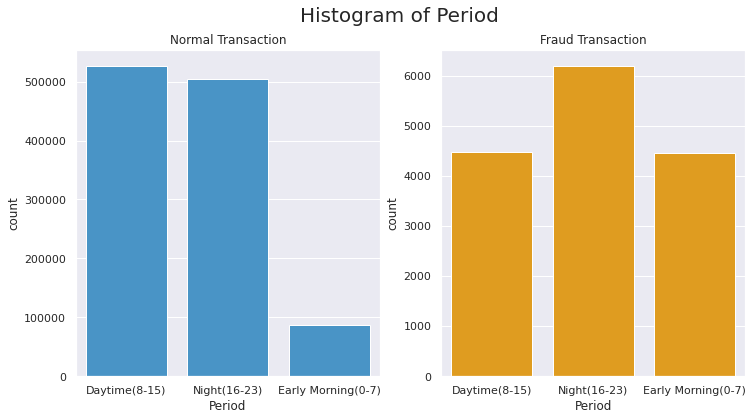

In [ ]:
# 早中晚分布：非盜刷 vs. 盜刷
# category = ["Morning", "Afternoon", "Night"] # 總類名稱
print(df0['Period'].value_counts())
print(df1['Period'].value_counts())

plt.figure(figsize = (12,6))
plt.suptitle('Histogram of Period', fontsize=20)    # 當有使用 plt.subplot，總 title
sns.set()
plt.subplot(1,2,1)
plt.title('Normal Transaction')
sns.countplot(df0['Period'], color = "#3498db", order = df0['Period'].value_counts().index)
plt.subplot(1,2,2)
plt.title('Fraud Transaction')
sns.countplot(df1['Period'], color = 'orange', order = df0['Period'].value_counts().index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


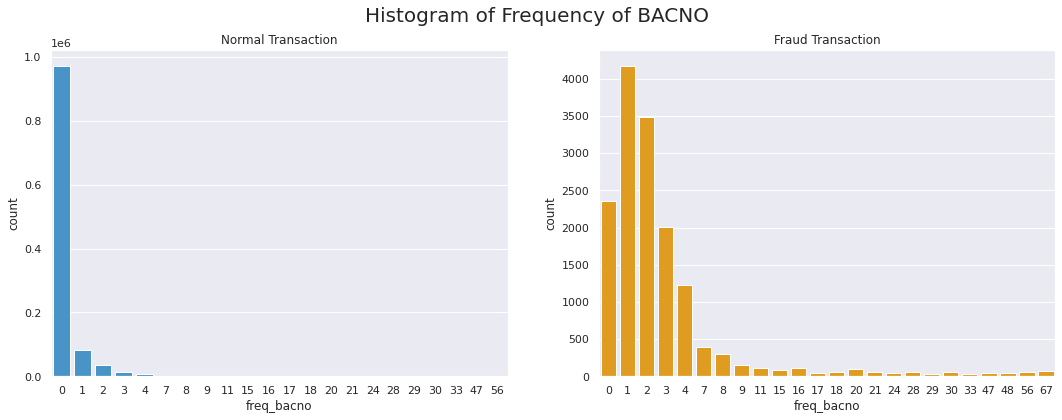

In [ ]:
# freq_bacno分布：非盜刷 vs. 盜刷
plt.figure(figsize = (18,6))
plt.suptitle('Histogram of Frequency of BACNO', fontsize=20)    # 當有使用 plt.subplot，總 title
sns.set()
plt.subplot(1,2,1)
plt.title('Normal Transaction')
sns.countplot(df0['freq_bacno'], color = "#3498db")
plt.subplot(1,2,2)
plt.title('Fraud Transaction')
sns.countplot(df1['freq_bacno'], color = 'orange')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


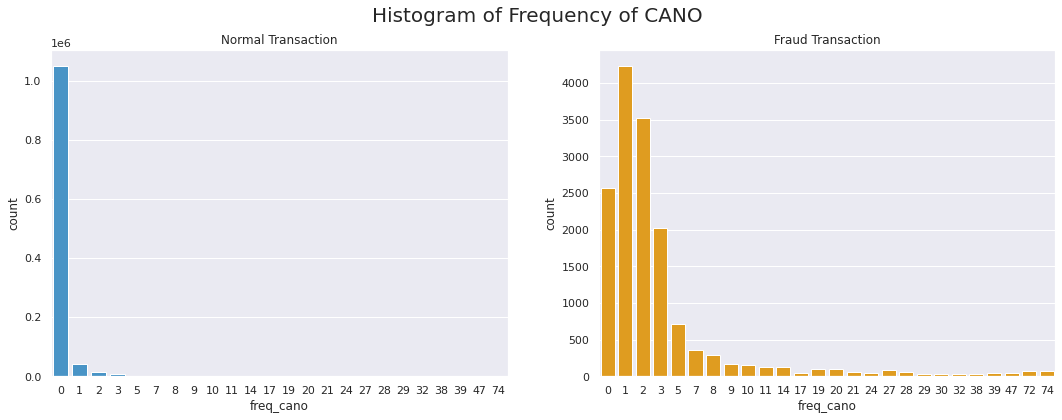

In [ ]:
# freq_cano分布：非盜刷 vs. 盜刷
plt.figure(figsize = (18,6))
plt.suptitle('Histogram of Frequency of CANO', fontsize=20)    # 當有使用 plt.subplot，總 title
sns.set()
plt.subplot(1,2,1)
plt.title('Normal Transaction')
sns.countplot(df0['freq_cano'], color = "#3498db")
plt.subplot(1,2,2)
plt.title('Fraud Transaction')
sns.countplot(df1['freq_cano'], color = 'orange')

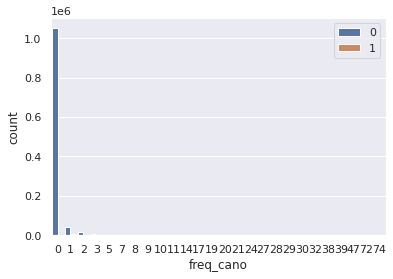

In [ ]:
# 這個畫出來結果太差，不採用
sns.set()
sns.countplot(x = 'freq_cano', hue = 'fraud_ind', data = train, )
plt.legend(loc='upper right')

## 錯誤案例分析

In [ ]:
pred = pd.read_csv('/content/gdrive/My Drive/Colab/FinTech/data/test_withPred.csv')

In [ ]:
pred.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,conam_log,loctm_hour,loctm_morning,loctm_afternoon,loctm_night,freq_cano,freq_bacno,conam_stz,conam_equal0,fraud_ind,predict
0,0,134508,45725,465.62,5,0,0,2,0,0,0,0,0,9,105114.0,451,0,0,5817,102,0,4376,6.145515,10,0,1,0,0,0,-0.477306,0,0,0
1,0,78377,2295,465.62,5,0,0,2,0,0,0,0,0,6,104918.0,451,0,0,5817,102,0,2943,6.145515,10,0,1,0,0,0,-0.477306,0,0,0
2,0,151054,197751,465.62,5,0,0,2,0,0,0,0,0,7,104917.0,451,0,0,5817,102,0,3387,6.145515,10,0,1,0,0,0,-0.477306,0,0,0
3,6716,150887,4541,930.31,5,62,0,4,0,0,5,0,0,8,142028.0,329,37560,0,5820,102,0,1765957,6.836592,14,0,1,0,2,2,0.681790,0,0,0
4,6882,110356,133430,0.00,5,0,0,0,0,0,0,0,0,9,143657.0,459,2461,0,0,102,0,611269,0.000000,14,0,1,0,0,0,-1.638722,1,0,0


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(pred['fraud_ind'], pred['predict']).ravel()
print(tn, fp, fn, tp)

362909 9329 788 4245


In [ ]:
TP = pred[(pred['fraud_ind'] == 1) & (pred['predict'] == 1)]  # tp
FP = pred[(pred['fraud_ind'] == 0) & (pred['predict'] == 1)]  # fp
FN = pred[(pred['fraud_ind'] == 1) & (pred['predict'] == 0)]  # fn
TN = pred[(pred['fraud_ind'] == 0) & (pred['predict'] == 0)]  # tn

In [ ]:
pred['cMat'] = ""
for i in range(pred.shape[0]):
  if (pred['fraud_ind'][i] == 1) & (pred['predict'][i] == 1):
    pred['cMat'][i] = 'TP'
  elif (pred['fraud_ind'][i] == 0) & (pred['predict'][i] == 1):
    pred['cMat'][i] = 'FP'
  elif (pred['fraud_ind'][i] == 1) & (pred['predict'][i] == 0):
    pred['cMat'][i] = 'FN'
  elif (pred['fraud_ind'][i] == 0) & (pred['predict'][i] == 0):
    pred['cMat'][i] = 'TN'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/py

In [ ]:
Result3 = '/content/gdrive/My Drive/Colab/FinTech/data/test_withPred_cMat.csv'
pred.to_csv(Result3, index = False)

4
['FN' 'FP' 'TN' 'TP']
TN    362909
FP      9329
TP      4245
FN       788
Name: cMat, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


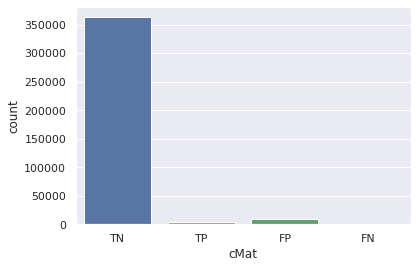

In [ ]:
print(len(np.unique(pred['cMat'])))
print(np.unique(pred['cMat']))
print(pred['cMat'].value_counts())
sns.set()
sns.countplot(pred['cMat'])

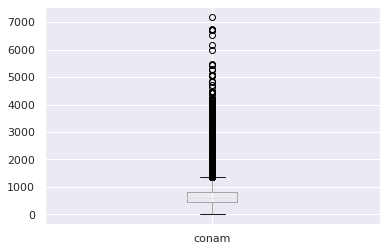

In [ ]:
pred.boxplot(column='conam')
plt.show()

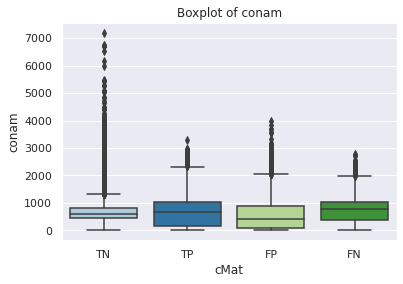

In [ ]:
plt.title("Boxplot of conam") # 圖的標題
sns.set_palette('Paired')
sns.boxplot(x = "cMat", y = "conam", data = pred)  # 繪製盒狀圖
#sns.boxplot(x="day",y="total_bill",hue="sex",data=df) # 繪製盒狀圖
plt.show() # 顯現圖形

0    279646
1     83263
Name: ecfg, dtype: int64
1    3706
0     539
Name: ecfg, dtype: int64
1    7525
0    1804
Name: ecfg, dtype: int64
1    608
0    180
Name: ecfg, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

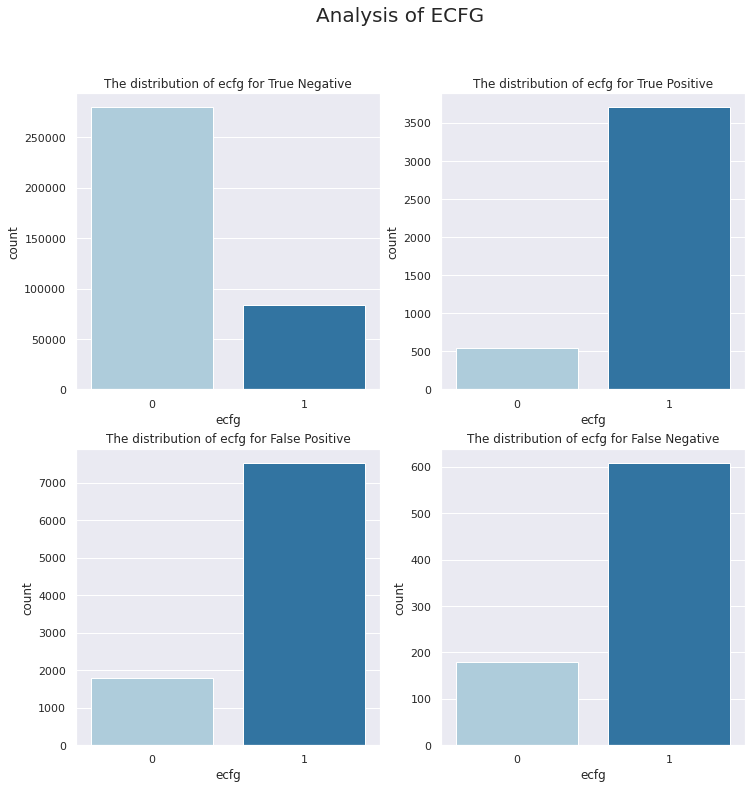

<Figure size 432x288 with 0 Axes>

In [ ]:
# ecfg分布：confusion matrix
print(TN['ecfg'].value_counts())
print(TP['ecfg'].value_counts())
print(FP['ecfg'].value_counts())
print(FN['ecfg'].value_counts())

plt.figure(figsize = (12,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of ECFG', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of ecfg for True Negative') 
sns.countplot(TN["ecfg"])
plt.subplot(2,2,2)
plt.title('The distribution of ecfg for True Positive') 
sns.countplot(TP["ecfg"])
plt.subplot(2,2,3)
plt.title('The distribution of ecfg for False Positive') 
sns.countplot(FP["ecfg"])
plt.subplot(2,2,4)
plt.title('The distribution of ecfg for False Negative') 
sns.countplot(FN["ecfg"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of ECFG.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

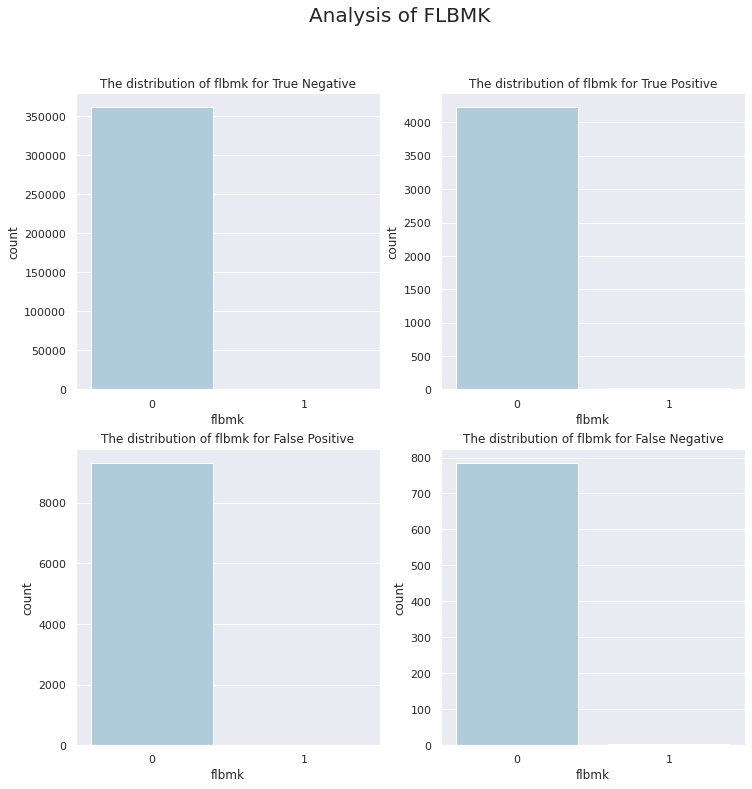

<Figure size 432x288 with 0 Axes>

In [ ]:
# flbmk分布：confusion matrix
print(TN['flbmk'].value_counts())
print(TP['flbmk'].value_counts())
print(FP['flbmk'].value_counts())
print(FN['flbmk'].value_counts())
plt.figure(figsize = (12,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of FLBMK', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of flbmk for True Negative') 
sns.countplot(TN["flbmk"])
plt.subplot(2,2,2)
plt.title('The distribution of flbmk for True Positive') 
sns.countplot(TP["flbmk"])
plt.subplot(2,2,3)
plt.title('The distribution of flbmk for False Positive') 
sns.countplot(FP["flbmk"])
plt.subplot(2,2,4)
plt.title('The distribution of flbmk for False Negative') 
sns.countplot(FN["flbmk"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of FLBMK.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

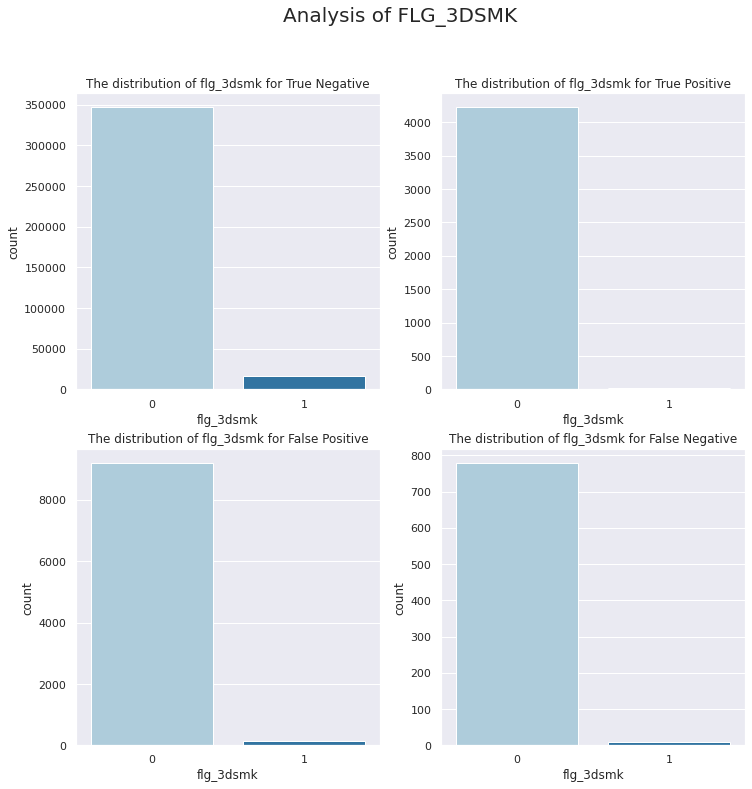

<Figure size 432x288 with 0 Axes>

In [ ]:
# flg_3dsmk分布：confusion matrix
print(TN['flbmk'].value_counts())
print(TP['flbmk'].value_counts())
print(FP['flbmk'].value_counts())
print(FN['flbmk'].value_counts())
plt.figure(figsize = (12,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of FLG_3DSMK', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of flg_3dsmk for True Negative') 
sns.countplot(TN["flg_3dsmk"])
plt.subplot(2,2,2)
plt.title('The distribution of flg_3dsmk for True Positive') 
sns.countplot(TP["flg_3dsmk"])
plt.subplot(2,2,3)
plt.title('The distribution of flg_3dsmk for False Positive') 
sns.countplot(FP["flg_3dsmk"])
plt.subplot(2,2,4)
plt.title('The distribution of flg_3dsmk for False Negative') 
sns.countplot(FN["flg_3dsmk"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of FLG_3DSMK.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

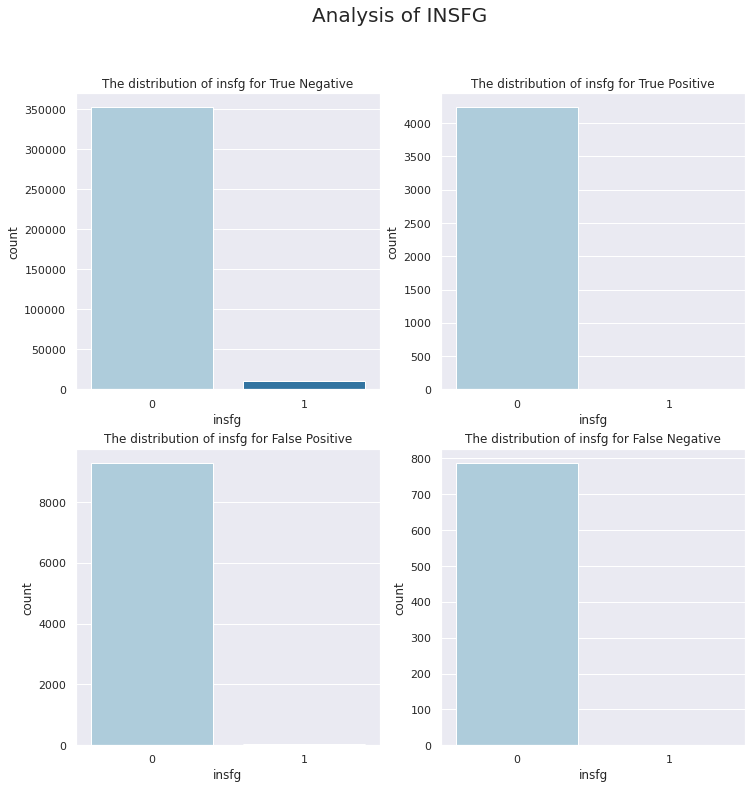

<Figure size 432x288 with 0 Axes>

In [ ]:
# insfg分布：confusion matrix
print(TN['insfg'].value_counts())
print(TP['insfg'].value_counts())
print(FP['insfg'].value_counts())
print(FN['insfg'].value_counts())
plt.figure(figsize = (12,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of INSFG', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of insfg for True Negative') 
sns.countplot(TN["insfg"])
plt.subplot(2,2,2)
plt.title('The distribution of insfg for True Positive') 
sns.countplot(TP["insfg"])
plt.subplot(2,2,3)
plt.title('The distribution of insfg for False Positive') 
sns.countplot(FP["insfg"])
plt.subplot(2,2,4)
plt.title('The distribution of insfg for False Negative') 
sns.countplot(FN["insfg"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of INSFG.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

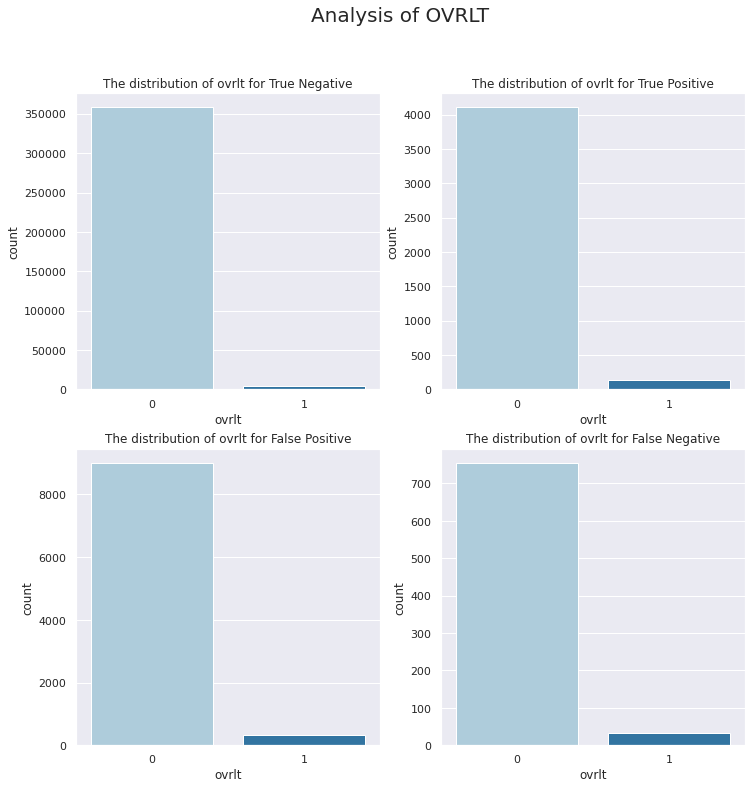

<Figure size 432x288 with 0 Axes>

In [ ]:
# ovrlt分布：confusion matrix
print(TN['ovrlt'].value_counts())
print(TP['ovrlt'].value_counts())
print(FP['ovrlt'].value_counts())
print(FN['ovrlt'].value_counts())
plt.figure(figsize = (12,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of OVRLT', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of ovrlt for True Negative') 
sns.countplot(TN["ovrlt"])
plt.subplot(2,2,2)
plt.title('The distribution of ovrlt for True Positive') 
sns.countplot(TP["ovrlt"])
plt.subplot(2,2,3)
plt.title('The distribution of ovrlt for False Positive') 
sns.countplot(FP["ovrlt"])
plt.subplot(2,2,4)
plt.title('The distribution of ovrlt for False Negative') 
sns.countplot(FN["ovrlt"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of OVRLT.png")

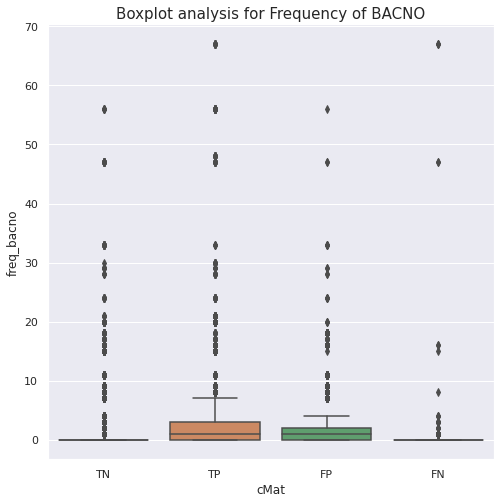

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize = (8,8))
plt.title('Boxplot analysis for Frequency of BACNO', fontsize = 15) # 圖的標題
sns.boxplot(x = "cMat", y = "freq_bacno", data = pred) # 繪製計數圖
plt.show() # 顯現圖形 
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Boxplot analysis for Frequency of BACNO.png")

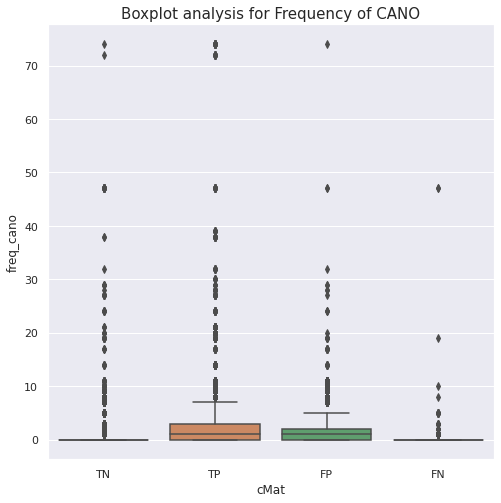

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize = (8,8))
plt.title('Boxplot analysis for Frequency of CANO', fontsize = 15) # 圖的標題
sns.boxplot(x = "cMat", y = "freq_cano", data = pred) # 繪製計數圖
plt.show() # 顯現圖形 
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Boxplot analysis for Frequency of CANO.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

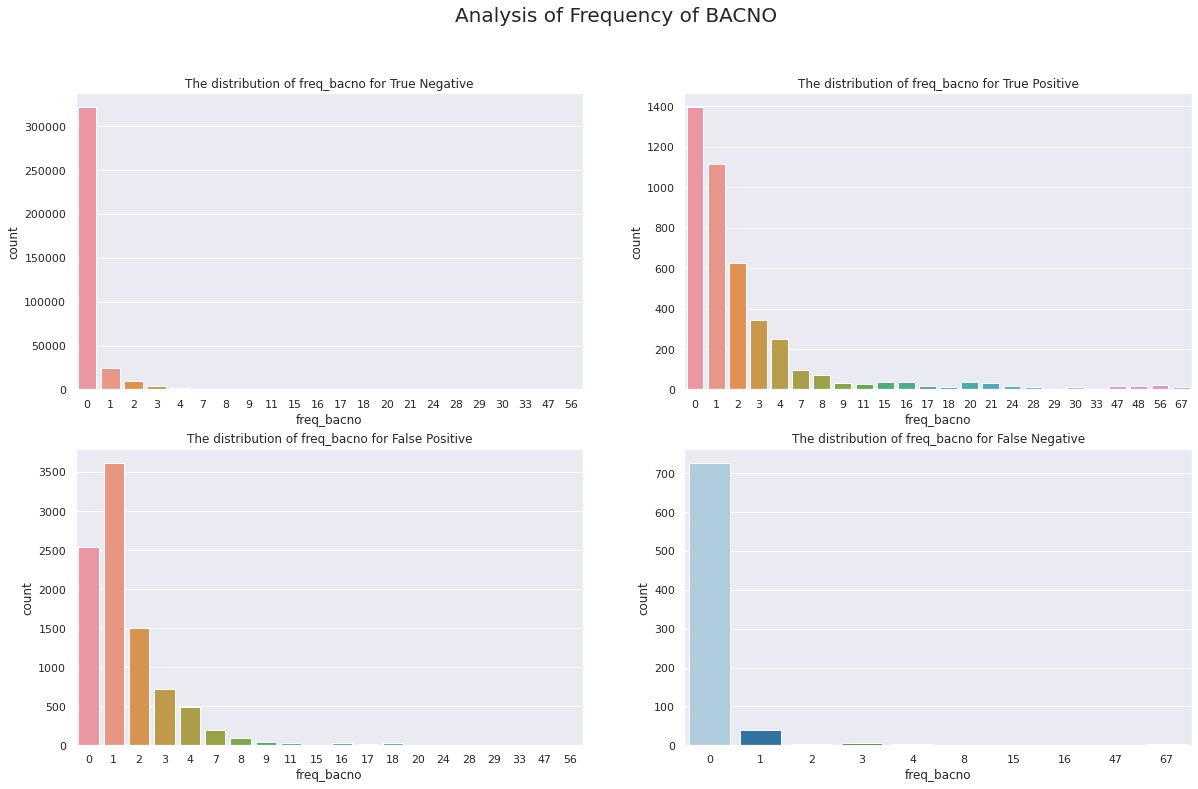

<Figure size 432x288 with 0 Axes>

In [ ]:
# freq_bacno分布：confusion matrix
plt.figure(figsize = (20,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of Frequency of BACNO', fontsize=20)     # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of freq_bacno for True Negative') 
sns.countplot(TN["freq_bacno"])
plt.subplot(2,2,2)
plt.title('The distribution of freq_bacno for True Positive') 
sns.countplot(TP["freq_bacno"])
plt.subplot(2,2,3)
plt.title('The distribution of freq_bacno for False Positive') 
sns.countplot(FP["freq_bacno"])
plt.subplot(2,2,4)
plt.title('The distribution of freq_bacno for False Negative') 
sns.countplot(FN["freq_bacno"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of Frequency of BACNO.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

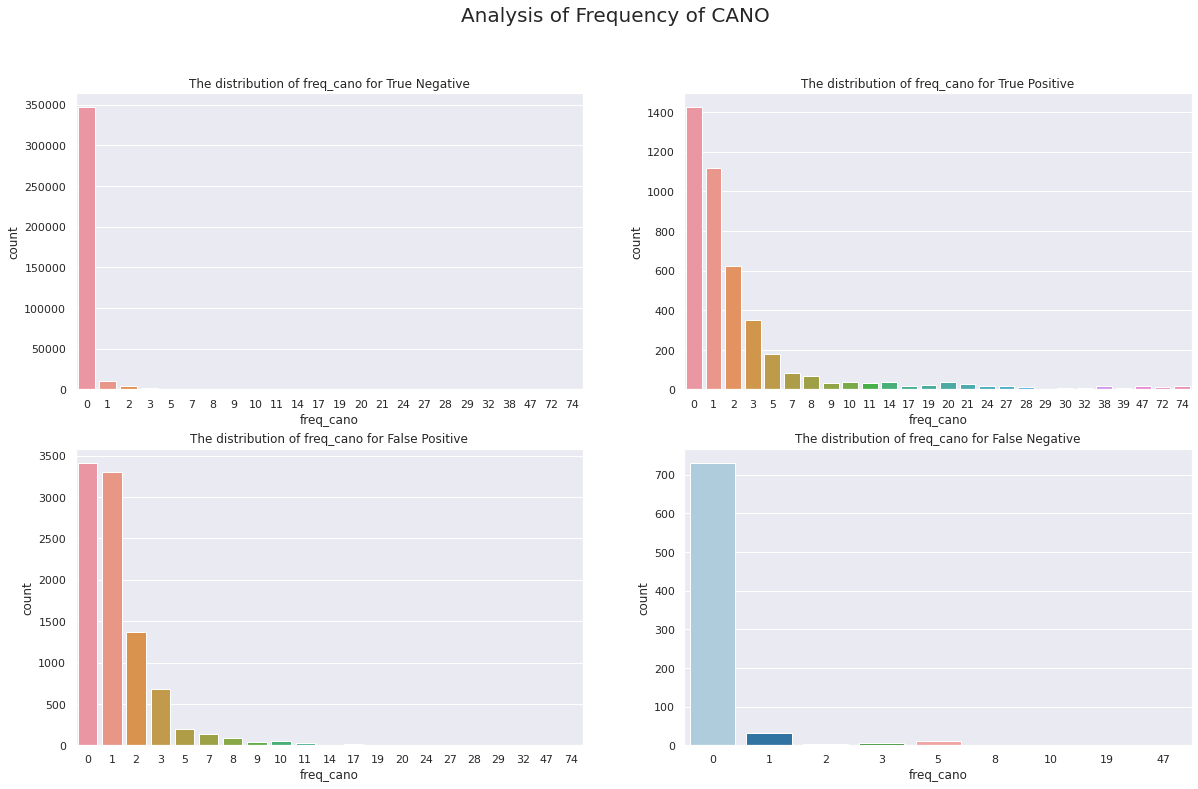

<Figure size 432x288 with 0 Axes>

In [ ]:
# freq_cano分布：confusion matrix
plt.figure(figsize = (20,12))
sns.set_palette('Paired')
plt.suptitle('Analysis of Frequency of CANO', fontsize=20)    # 當有使用 plt.subplot，總 title

plt.subplot(2,2,1)
plt.title('The distribution of freq_cano for True Negative') 
sns.countplot(TN["freq_cano"])
plt.subplot(2,2,2)
plt.title('The distribution of freq_cano for True Positive') 
sns.countplot(TP["freq_cano"])
plt.subplot(2,2,3)
plt.title('The distribution of freq_cano for False Positive') 
sns.countplot(FP["freq_cano"])
plt.subplot(2,2,4)
plt.title('The distribution of freq_cano for False Negative') 
sns.countplot(FN["freq_cano"])
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/FinTech/figure/Analysis of Frequency of CANO.png")

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Colab/FinTech/data/train_freq.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab/FinTech/data/test_freq.csv')

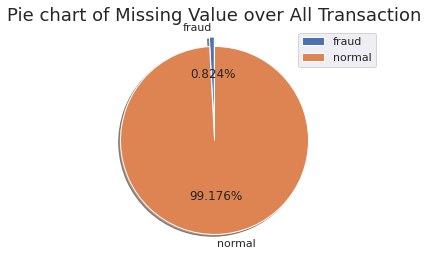

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '  缺失值', '無缺失值', 'Dogs', 'Logs'
sizes = [0.824, 100-0.824]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = ['fraud','normal']  
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, explode=explode, autopct='%1.3f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie chart of Missing Value over All Transaction", {"fontsize" : 18})
plt.legend(loc = "best")
plt.show()

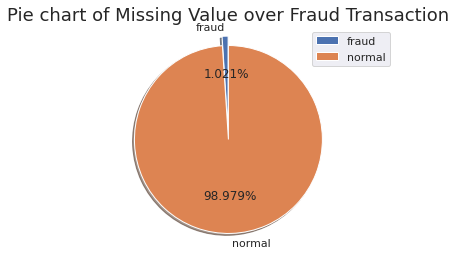

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '  缺失值', '無缺失值', 'Dogs', 'Logs'
sizes = [1.021, 100-1.021]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = ['fraud','normal']  
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, explode=explode, autopct='%1.3f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie chart of Missing Value over Fraud Transaction", {"fontsize" : 18})
plt.legend(loc = "best")
plt.show()